In [1]:
import os
import FlowCytometryTools as fct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
batch_date = '02_07_20'
fcs_locs = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Pooled_Runs"
fcs_files = os.listdir(fcs_locs)
dates_tubes = [[f[:8].replace("_","-"), f[9:-4], f] for f in fcs_files if batch_date in f]
file_table = pd.DataFrame(data=dates_tubes, columns=['proc_date', 'Tube', 'fileName'])
file_table['pathName'] = file_table['fileName'].apply(lambda x: os.path.join(fcs_locs, x))
assert len(file_table['Tube'].unique()) == len(file_table['Tube'])
print("{} files detected, {} selected from {}".format(len(fcs_files), len(file_table), batch_date))
file_table.head()

193 files detected, 52 selected from 02_07_20


,proc_date,Tube,fileName,pathName
0,02-07-20,JustWater,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
1,02-07-20,Tube_1,02_07_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
2,02-07-20,Tube_2,02_07_20_Tube_2.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
3,02-07-20,Tube_3,02_07_20_Tube_3.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
4,02-07-20,Tube_4,02_07_20_Tube_4.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...


In [3]:
def pull_relavent_metadata(x):
    meta = x.get_meta()
    _channels_ = meta['_channels_'].copy()
    voltages = _channels_[_channels_['$PnN'].str.endswith("-A")].set_index('$PnN')['$PnV'].to_dict()
    voltages = {i[:-2]+' gain':j for i, j in voltages.items()}
    voltages['startTime'] = meta['$BTIM']
    voltages['endTime'] = meta['$ETIM']
    return voltages

In [4]:
other_channels = ['Time']
measured_channels = ["FSC-A", "SSC-A", "488 530/30-A", "488 585/42-A", "488 670LP-A",
                    "488 780/60-A", "633 660/20-A", "633 780/60-A"]
b_value = 400
data_mats, meta_datas = {}, {}
for tn, pn in file_table[['Tube', 'pathName']].values:
    print("Reading {}     ".format(tn), sep=' ', end='\r', flush=True)
    
    data_obj = fct.FCMeasurement(ID=tn, datafile=pn)
    temp_df1 = data_obj.data[measured_channels + other_channels]
    temp_df2 = temp_df1.copy()
    for ch_ in measured_channels:
        temp_df2[ch_] = data_obj.transform('hlog', channels=[ch_], b=b_value).data[ch_]
        if tn == 'Tube_10':
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df1[ch_].values, [0, 25, 50, 75, 100])
            print("Pre-transform {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df2[ch_].values, [0, 25, 50, 75, 100])
            print("Post {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))

    data_mats[tn] = temp_df2.copy()    
    meta_datas[tn] = pull_relavent_metadata(data_obj)

Pre-transform FSC-A	-334.05	-39.10	11.90	92.65	262143.00
Post FSC-A	-1515.29	-179.24	54.58	424.25	9993.35
Pre-transform SSC-A	171.45	313.69	490.22	1262.38	262143.00
Post SSC-A	783.39	1424.62	2195.03	4524.22	9993.35
Pre-transform 488 530/30-A	-300.99	-30.48	57.15	177.80	262143.00
Post 488 530/30-A	-1367.89	-139.75	261.89	812.23	9993.35
Pre-transform 488 585/42-A	-77.47	-10.16	0.00	11.43	262143.00
Post 488 585/42-A	-354.86	-46.60	0.00	52.42	9993.35
Pre-transform 488 670LP-A	-91.44	-10.16	1.27	13.97	225741.23
Post 488 670LP-A	-418.72	-46.60	5.83	64.07	9872.54
Pre-transform 488 780/60-A	-128.27	-12.70	0.00	16.51	262143.00
Post 488 780/60-A	-586.83	-58.25	0.00	75.72	9993.35
Pre-transform 633 660/20-A	-112.66	-19.65	3.93	32.75	262143.00
Post 633 660/20-A	-515.62	-90.11	18.03	150.15	9993.35
Pre-transform 633 780/60-A	-166.37	-26.20	1.31	30.13	262143.00
Post 633 780/60-A	-760.30	-120.14	6.01	138.15	9993.35


In [5]:
file_table['proc_datetime'] = pd.to_datetime(file_table['proc_date'])
exp_cnt_file = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/RockCreekCytometrySamples_Feb17.xlsx"
exp_cnt_df_pre = pd.read_excel(exp_cnt_file, sheet_name='Cytometry Filtered Tube Labels')
avail_dates, this_date = exp_cnt_df_pre['Prefilter-Date'].unique(), list(file_table['proc_datetime'].unique())
assert len(this_date) == 1
print("Which of these matches most closely after {}?\n".format(this_date[0]))
print(avail_dates)
selection = int(input())
selected_date = avail_dates[selection]
exp_cnt_df = exp_cnt_df_pre.copy()[exp_cnt_df_pre['Prefilter-Date'] == selected_date]
print("You picked the {} records from {} <- to match -> {}".format(len(exp_cnt_df), selected_date, this_date[0]))


Which of these matches most closely after 2020-02-07T00:00:00.000000000?

['2020-02-05T00:00:00.000000000' '2020-01-31T00:00:00.000000000'
 '2019-11-26T00:00:00.000000000' '2019-12-04T00:00:00.000000000'
                           'NaT']
0
You picked the 50 records from 2020-02-05T00:00:00.000000000 <- to match -> 2020-02-07T00:00:00.000000000


In [7]:
exp_cnt_df['Tube_fmt'] = exp_cnt_df['Tube'].apply(lambda x: "Tube_" + str(int(x)))

files_observed = sorted(list(set(file_table['Tube'])))
files_observed.remove("JustWater")
files_observed.remove("Tube_8_R2")
files_expected = sorted(list(set(exp_cnt_df['Tube_fmt'])))

exp_cols = [ 'Sample Date', 'Sample Depth', 'Sample Time', 'Sample Station']
exp_cnt_df['data_index'] = pd.Series(index=exp_cnt_df.index)
for ix in range(max([len(files_observed), len(files_expected)])): 
    strp1, strp2 = "", ""
    if ix < len(files_observed):
        strp1 = files_observed[ix]
    if ix < len(files_expected):
        strp2 = files_expected[ix]
    print("Matched {} to {}".format(strp2, strp1))
    
    rs_1 = exp_cnt_df['Tube_fmt'] == files_expected[ix]
    ix_ex = list(exp_cnt_df.index[rs_1])[0]
    rs_2 = file_table['Tube'] == files_observed[ix]
    ix_obs = file_table.loc[rs_2, 'Tube'].values[0]
    print("\t{}".format(exp_cnt_df.loc[ix_ex, exp_cols].astype(str).values))
    assert rs_1.sum() == rs_2.sum() == 1
    exp_cnt_df.loc[ix_ex, 'data_index'] = ix_obs
    

Matched Tube_1 to Tube_1
	['2019-07-26 00:00:00' 'TOP' 'AM' 'RC2']
Matched Tube_10 to Tube_10
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC9']
Matched Tube_11 to Tube_11
	['2019-07-29 00:00:00' 'BOTTOM' 'PM' 'RC7']
Matched Tube_12 to Tube_12
	['2019-07-29 00:00:00' 'END BLANK' 'PM' 'nan']
Matched Tube_13 to Tube_13
	['2019-07-29 00:00:00' 'BOTTOM' 'PM' 'RC2']
Matched Tube_14 to Tube_14
	['2019-07-30 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_15 to Tube_15
	['2019-07-29 00:00:00' 'START BLANK' 'nan' 'nan']
Matched Tube_16 to Tube_16
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC7']
Matched Tube_17 to Tube_17
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC1']
Matched Tube_18 to Tube_18
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC2-BUOY']
Matched Tube_19 to Tube_19
	['2019-07-29 00:00:00' 'TOP' 'PM' 'RC2']
Matched Tube_2 to Tube_2
	['2019-07-26 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_20 to Tube_20
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC1']
Matched Tube_21 to Tube_21
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC9

In [8]:
file_table2 = file_table.set_index("Tube")

meta_df = pd.DataFrame(meta_datas).T.sort_index()

file_table3 = pd.concat((file_table2, meta_df), axis=1, sort=True, verify_integrity=True)

mad_gains = [i for i in file_table3.columns if 'gain' in i]
file_table3['all_gains'] = file_table3[mad_gains].apply(tuple, axis=1)
num_gains = file_table3['all_gains'].unique().shape[0]
print("There are {} sets of gain settings".format(num_gains))
if num_gains > 1:
    settings_n, settings_c = np.unique(file_table3['all_gains'].values, return_counts=True)
    for setn, setc in zip(settings_n, settings_c):
        print("\t{} samples have this setting: {}".format(setc, list(zip(mad_gains, setn))))
        print("\n\t{}".format(file_table3.index[file_table3['all_gains'] == setn]))

file_table3.drop('all_gains', inplace=True, axis=1)

There are 1 sets of gain settings


In [9]:
file_table3

,proc_date,fileName,pathName,proc_datetime,FSC gain,SSC gain,488 530/30 gain,488 585/42 gain,488 670LP gain,488 780/60 gain,633 660/20 gain,633 780/60 gain,startTime,endTime
JustWater,02-07-20,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,19:04:38,19:06:48
Tube_1,02-07-20,02_07_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,16:25:40,16:27:03
Tube_10,02-07-20,02_07_20_Tube_10.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:03:34,17:04:56
Tube_11,02-07-20,02_07_20_Tube_11.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:05:57,17:08:58
Tube_12,02-07-20,02_07_20_Tube_12.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:09:45,17:11:06
Tube_13,02-07-20,02_07_20_Tube_13.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:12:01,17:13:38
Tube_14,02-07-20,02_07_20_Tube_14.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:15:44,17:18:45
Tube_15,02-07-20,02_07_20_Tube_15.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:21:28,17:22:56
Tube_16,02-07-20,02_07_20_Tube_16.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:23:59,17:25:30
Tube_17,02-07-20,02_07_20_Tube_17.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:29:11,17:30:45


In [39]:
def filter_w_thresh(df, b_t, minmax, thresh):
    proc_order = list(b_t.index)
    index_sets = []
    mat_ = [df[po].values.reshape(-1,1) for po in proc_order]
    for col_i, col in enumerate(mat_):
        index_sets.append(( col >= b_t.loc[proc_order[col_i], minmax[0]] ) & ( col <= b_t.loc[proc_order[col_i], minmax[1]] ))
    
    bmat_ = np.hstack(index_sets).astype(int).sum(1)
    return list(df.index[bmat_ >= bmat_.max() - thresh])

30969 records in negative controls
Beads: 1001, Noise: 29968


<Figure size 432x288 with 0 Axes>

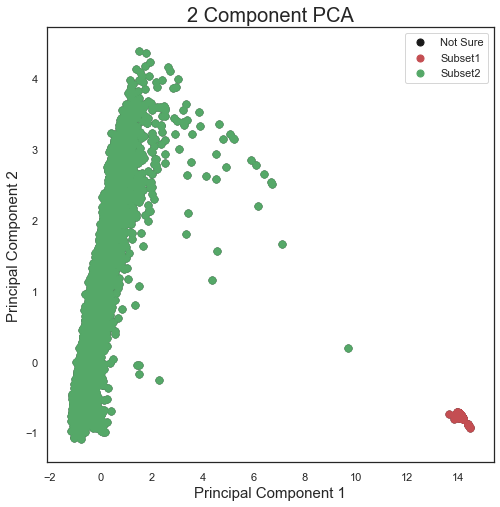

In [88]:
negative_controls = ['JustWater', 'Tube_5']
PC_bead_threshold = 12

bead_df = pd.concat([data_mats[i].copy() for i in negative_controls], axis=0, ignore_index=True)
print("{} records in negative controls".format(bead_df.shape[0]))

real_cols = [i for i in bead_df.columns if i != 'Time']
x = StandardScaler().fit_transform(bead_df[real_cols].values)
pca = PCA(n_components=2, random_state=0)
jb_pca = pca.fit(x)
principalDf = pd.DataFrame(data = jb_pca.transform(x), columns = ['PC1', 'PC2'])

subset1 = list(principalDf.index[principalDf['PC1'] > PC_bead_threshold])
subset2 = list(principalDf.index[principalDf['PC1'] <= PC_bead_threshold])

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [subset1, subset2]
labels = ['Subset1', 'Subset2']
colors = ['r', 'g']

ax.scatter(principalDf.loc[:, 'PC1'], principalDf.loc[:, 'PC2'], c='k', label='Not Sure', s = 50)

for target, color, lab in zip(targets, colors, labels):
    _ = ax.scatter(principalDf.loc[target, 'PC1'],
               principalDf.loc[target, 'PC2'], 
               c=color, label=lab, s = 50)

_ =ax.legend()
print("Beads: {}, Noise: {}".format(len(subset1), len(subset2)))

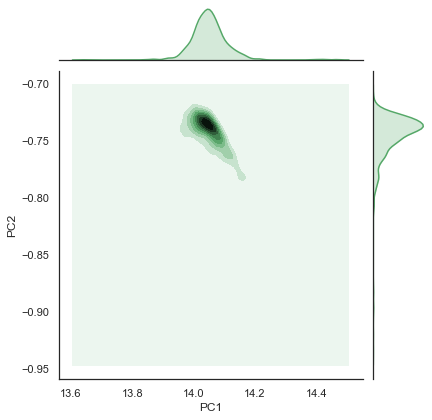

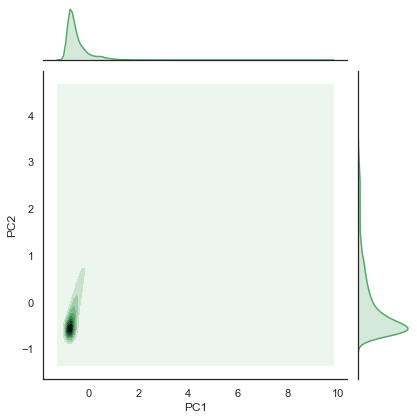

In [89]:
import seaborn as sns; 
sns.set(style="white", color_codes=True)
np.random.seed(0)

g = sns.jointplot("PC1", "PC2", data=principalDf.loc[subset1, :], kind="kde", color="g")
g2 = sns.jointplot("PC1", "PC2", data=principalDf.loc[subset2, :], kind="kde", color="g")

In [118]:
real_cols = [i for i in bead_df.columns if not i in ['Time', 'FSC-A']]
print(len(subset1), len(subset2))
ss1_thres = bead_df.loc[subset1, real_cols].describe().T[['min', 'max']]
ss2_thres = bead_df.loc[subset2, real_cols].describe([0.025, 0.975]).T[['2.5%', '97.5%']]
ss2_thres.columns = ['min', 'max']
for rc in real_cols:
    is_ss2_gt_ss1 = ss2_thres.loc[rc, 'min'] > ss1_thres.loc[rc, 'max']
    is_ss1_gt_ss2 = ss1_thres.loc[rc, 'min'] > ss2_thres.loc[rc, 'max']
    print("{}  -- SS1 > SS2: {}, SS2 > SS1: {}".format(rc, is_ss1_gt_ss2, is_ss2_gt_ss1))
    
print(bead_df.min(0))
pd.concat((ss2_thres, ss1_thres), axis=1)

1001 29968
SSC-A  -- SS1 > SS2: True, SS2 > SS1: False
488 530/30-A  -- SS1 > SS2: True, SS2 > SS1: False
488 585/42-A  -- SS1 > SS2: True, SS2 > SS1: False
488 670LP-A  -- SS1 > SS2: True, SS2 > SS1: False
488 780/60-A  -- SS1 > SS2: True, SS2 > SS1: False
633 660/20-A  -- SS1 > SS2: True, SS2 > SS1: False
633 780/60-A  -- SS1 > SS2: True, SS2 > SS1: False
FSC-A          -2007.075562
SSC-A            679.407166
488 530/30-A   -1577.111816
488 585/42-A    -343.244781
488 670LP-A     -447.730164
488 780/60-A    -557.872620
633 660/20-A    -635.094238
633 780/60-A    -724.551941
Time              51.400002
dtype: float32


,min,max,min,max
SSC-A,1002.199036,6805.490991,9712.812500,9993.349609
488 530/30-A,-800.697388,1350.849854,9993.349609,9993.349609
488 585/42-A,-151.388123,145.568924,7962.514648,9200.217773
488 670LP-A,-163.025620,151.388123,7952.768555,9112.543945
488 780/60-A,-174.661957,394.487514,9200.943359,9993.349609
633 660/20-A,-276.129242,389.972626,9993.349609,9993.349609
633 780/60-A,-336.064301,377.995850,9993.349609,9993.349609


[0.86992323 0.09680676]
SSC-A	0.2502620816230774	0.9508735537528992
488 530/30-A	0.3717419505119324	0.07160693407058716
488 585/42-A	0.398926317691803	-0.1577286422252655
488 670LP-A	0.39977383613586426	-0.15132415294647217
488 780/60-A	0.40080127120018005	-0.09949399530887604
633 660/20-A	0.40045467019081116	-0.105398029088974
633 780/60-A	0.3990110754966736	-0.14807820320129395
(183304, 2)
[2737, 142946, 4963]


<Figure size 432x288 with 0 Axes>

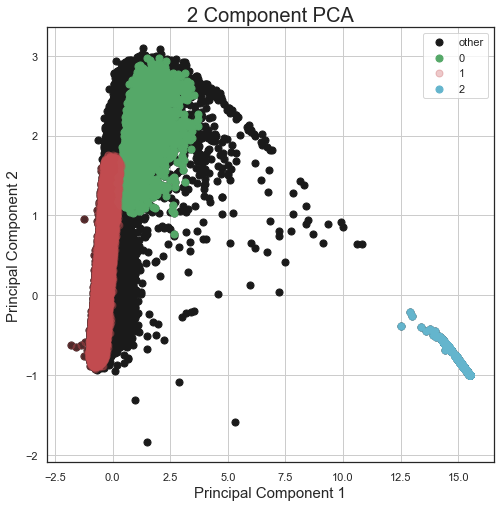

,Noise_min,Noise_max,Cell_min,Cell_max,Bead_min,Bead_max
488 530/30-A,-1413,1350,1945,6871,9993,9993
488 585/42-A,-459,145,-128,285,6544,9993
488 670LP-A,-650,151,-75,662,6420,9993
488 780/60-A,-898,389,-17,4226,7800,9993
633 660/20-A,-986,389,-42,4201,9883,9993
633 780/60-A,-1304,377,-234,1421,8906,9993
SSC-A,633,6805,5422,9792,9017,9993


In [119]:
test_pack = ['Tube_10', 'Tube_11', 'Tube_47', 'Tube_6', 'Tube_42']

bnc16_df = pd.concat([data_mats[i] for i in test_pack], ignore_index=True)
for col in ss2_thres.index:
    ss2_thres.loc[col, 'min'] = bnc16_df[col].min()

x = StandardScaler().fit_transform(bnc16_df[real_cols].values)
pca2 = PCA(n_components=2, random_state=0)
bnc_pca = pca2.fit(x)
print(bnc_pca.explained_variance_ratio_)
for rc_ in range(len(real_cols)):
    print("{}\t{}\t{}".format(real_cols[rc_], bnc_pca.components_[0, rc_], bnc_pca.components_[1, rc_]))

bnc_pc2_df = pd.DataFrame(data = bnc_pca.transform(x), columns = ['PC1', 'PC2'])

bead_events = list(bnc_pc2_df.index[bnc_pc2_df['PC1'] > 12])
other_events = list(bnc_pc2_df.index[(bnc_pc2_df['PC1'] > 0.85) & (bnc_pc2_df['PC1'] < 9) & (bnc_pc2_df['PC2'] < 3) ])
noise_events = filter_w_thresh(bnc16_df[real_cols].copy(), ss2_thres.loc[real_cols, :], ['min', 'max'],  0)
other_events = list(set(other_events) - set(noise_events))

noise_lim = bnc16_df.loc[noise_events, real_cols].describe([0.0, 1.00]).T.iloc[:, [-4,-2]]
cell_lim = bnc16_df.loc[other_events, real_cols].describe([0.05, 0.95]).T.iloc[:, [-4,-2]]
bead_lim = bnc16_df.loc[bead_events, real_cols].describe([0.00, 1.0]).T.iloc[:, [-4,-2]]

noise_lim.columns = ['Noise_min', 'Noise_max']
bead_lim.columns = ['Bead_min', 'Bead_max']
cell_lim.columns = ['Cell_min', 'Cell_max']

#blue_chan = [i for i in cell_lim.index if '488 ' in i]
#cell_lim.loc[blue_chan, 'Cell_min'] = cell_lim.loc[blue_chan, 'Cell_min']*.2
#cell_lim.loc['SSC-A', 'Cell_min'] = noise_lim.loc['SSC-A', 'Noise_min']

cell_events = filter_w_thresh(bnc16_df[real_cols].copy(), cell_lim.loc[real_cols, :], ['Cell_min', 'Cell_max'],  0)

print(bnc_pc2_df.shape)

targets = [cell_events, noise_events, bead_events]
print([len(i) for i in targets])
labels = ['0', '1', '2']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(bnc_pc2_df.loc[:, 'PC1'], 
           bnc_pc2_df.loc[:, 'PC2'], 
           c='k', label='other', s=50)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    ax.scatter(bnc_pc2_df.loc[target, 'PC1'],
               bnc_pc2_df.loc[target, 'PC2'], 
               c=color, label=lab, s = 50, alpha=alpha_)
ax.legend()
ax.grid()

plt.show()
ss_mix = pd.concat((noise_lim, cell_lim, bead_lim), sort=True, axis=1)
ss_mix.astype(int)

In [120]:
fixative_dilution = 0.2 # mL added to the original sample 
bead_concentration = 1e6 # beads per mL
bead_volume = 0.05 # mL
cells_volume = 0.5 # mL 
ratio_multiplier = ((bead_concentration*bead_volume)/(cells_volume))/fixative_dilution

all_count_df = file_table3.copy()
new_columns = ['runtime', 'beads', 'cells', 'noise', 'concentration', 'noise_rate']
for nc in new_columns:
    all_count_df[nc] = pd.Series(index=all_count_df.index)

for tube_n, bnci_df in data_mats.items():
    beadi_events = filter_w_thresh(bnci_df.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
    noisei_events = filter_w_thresh(bnci_df.copy(), noise_lim, ['Noise_min', 'Noise_max'], 0)
    celli_events = filter_w_thresh(bnci_df.copy(), cell_lim, ['Cell_min', 'Cell_max'], 0)

    all_count_df.loc[tube_n, ['beads', 'cells', 'noise']] = [len(beadi_events), 
                                                             len(set(celli_events) - set(beadi_events) - set(noisei_events)), 
                                                             len(noisei_events)]
    all_count_df.loc[tube_n, 'runtime'] = (bnci_df.Time.max() - bnci_df.Time.min())/100
    print(all_count_df.loc[tube_n, 'cells'])
    
# cells/bead * beads/mL = cells/mL
all_count_df['concentration'] = (all_count_df['cells'] /(all_count_df['beads']+1))*ratio_multiplier
all_count_df['noise_conc'] = (all_count_df['noise'] /(all_count_df['beads']+1))*ratio_multiplier


1.0
407.0
589.0
254.0
1752.0
102.0
198.0
452.0
16.0
7.0
215.0
594.0
122.0
8.0
105.0
76.0
20.0
107.0
61.0
109.0
233.0
138.0
87.0
1050.0
2843.0
355.0
1392.0
16.0
435.0
145.0
21.0
124.0
1362.0
162.0
629.0
234.0
232.0
506.0
217.0
116.0
211.0
620.0
431.0
115.0
94.0
35.0
456.0
158.0
1708.0
199.0
34.0
72.0


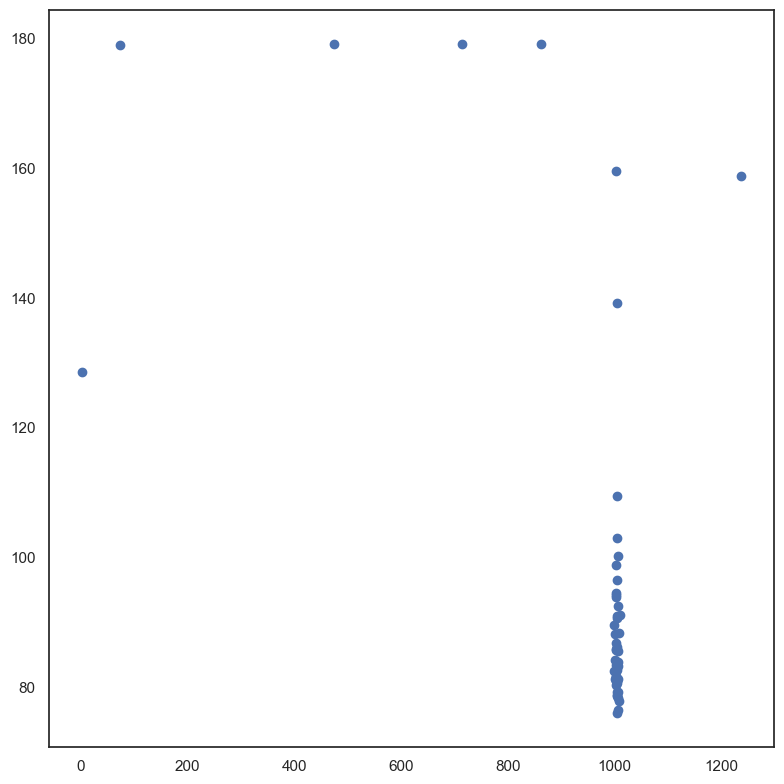

,proc_date,fileName,pathName,proc_datetime,FSC gain,SSC gain,488 530/30 gain,488 585/42 gain,488 670LP gain,488 780/60 gain,...,633 780/60 gain,startTime,endTime,runtime,beads,cells,noise,concentration,noise_rate,noise_conc
JustWater,02-07-20,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,616,19:04:38,19:06:48,128.650000,2.0,1.0,9101.0,1.666667e+05,NaN,1.516833e+09
Tube_11,02-07-20,02_07_20_Tube_11.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,616,17:05:57,17:08:58,179.234004,715.0,122.0,21149.0,8.519553e+04,NaN,1.476885e+07
Tube_14,02-07-20,02_07_20_Tube_14.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,616,17:15:44,17:18:45,179.144004,475.0,76.0,18819.0,7.983193e+04,NaN,1.976786e+07
Tube_3,02-07-20,02_07_20_Tube_3.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,616,16:34:01,16:37:02,179.025000,73.0,254.0,26730.0,1.716216e+06,NaN,1.806081e+08
Tube_47,02-07-20,02_07_20_Tube_47.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,616,18:42:16,18:44:57,158.809004,1237.0,1708.0,50007.0,6.898223e+05,NaN,2.019669e+07


In [121]:
###### print(all_count_df[['beads', 'runtime']].describe())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), num=5, dpi=100)
ax.scatter(all_count_df['beads'].values, all_count_df['runtime'], marker='o')
plt.tight_layout()
plt.show()

clean_counts = all_count_df.copy()[all_count_df['beads'] > 800]
all_count_df.loc[((all_count_df['beads'] < 800) | (all_count_df['beads'] > 1025)) | (all_count_df['runtime'] < 50) , :]

<Figure size 432x288 with 0 Axes>

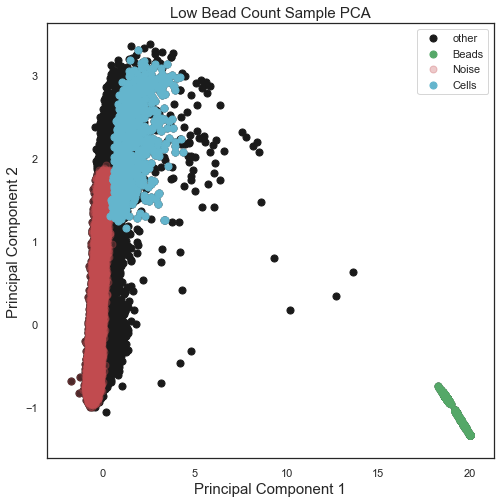

In [122]:
check_sample2 = pd.concat([data_mats[i] for i in ['JustWater', 'Tube_11', 'Tube_14', 'Tube_3', 'Tube_47']], ignore_index=True)

pca2 = PCA(n_components=2, random_state=0)
x = StandardScaler().fit_transform(check_sample2[real_cols].values)
cs_pca = pca2.fit(x)
cs_pc2_df = pd.DataFrame(data = cs_pca.transform(x), columns = ['PC1', 'PC2'])

bead_cs_v2 = filter_w_thresh(check_sample2.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
noise_cs_v2 = filter_w_thresh(check_sample2.copy(), noise_lim, ['Noise_min', 'Noise_max'], 0) 
cells_cs_v2 = filter_w_thresh(check_sample2.copy(), cell_lim, ['Cell_min', 'Cell_max'], 0)

assert len(set(bead_cs_v2).intersection(set(noise_cs_v2))) == 0
assert len(set(noise_cs_v2).intersection(set(cells_cs_v2))) == 0
assert len(set(bead_cs_v2).intersection(set(cells_cs_v2))) == 0

targets = [bead_cs_v2, noise_cs_v2, cells_cs_v2]
labels = ['Beads', 'Noise', 'Cells']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Low Bead Count Sample PCA', fontsize = 15)
xtpytp = cs_pc2_df[['PC1', 'PC2']].sample(50000)
ax.scatter(xtpytp['PC1'], xtpytp['PC2'], c='k', label='other', s=50)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    subtarg = set(target).intersection(set(xtpytp.index))
    ax.scatter(xtpytp.loc[subtarg, 'PC1'],
               xtpytp.loc[subtarg, 'PC2'], 
               c=color, label=lab, s = 50, alpha=alpha_)
ax.legend()
plt.show()

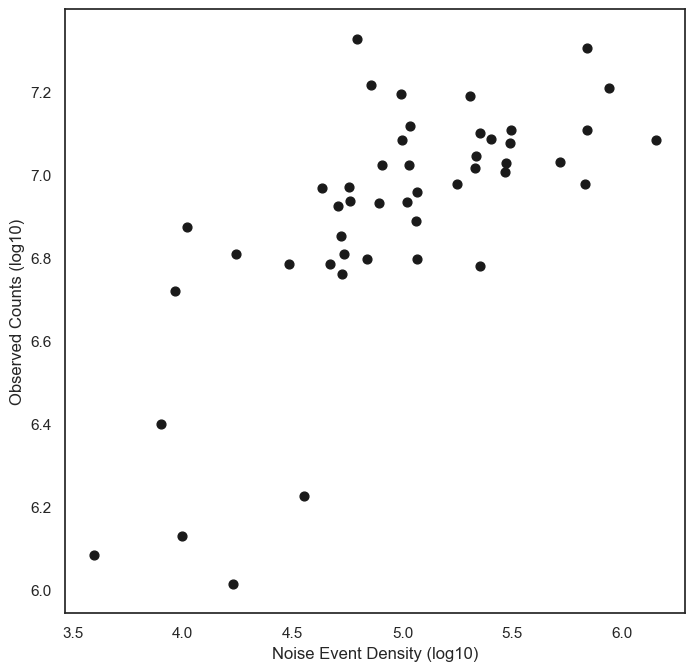

,Sample Date,Sample Depth,Sample Time,Sample Station,conc_int
143,2019-07-29,END BLANK,PM,NaN,3968
96,2019-07-24,END BLANK,PM,NaN,7968
117,2019-07-26,START BLANK,NaN,NaN,9269
142,2019-07-29,START BLANK,NaN,NaN,9930
0,2019-07-08,TOP,PM,A,10458
189,2020-02-05,NEGATIVE CONTROL,NaN,NaN,16881
30,2019-07-10,END BLANK,NaN,NaN,17430
145,2019-07-29,BOTTOM,AM,RC1,30348
188,2020-02-05,POSITIVE CONTROL,NaN,NaN,35820
159,2019-07-29,BOTTOM,AM,RC9,43240


In [123]:
clean_counts['log-noise'] = clean_counts['noise_conc'].apply(lambda x: np.log10(x) if x > 0 else 0)
clean_counts['log-conc'] = clean_counts['concentration'].apply(lambda x: np.log10(x) if x > 0 else 0)

for nc in ['log-conc','log-noise', 'concentration']:
    exp_cnt_df[nc] = pd.Series(index=exp_cnt_df.index)    
    for ix in exp_cnt_df.index[exp_cnt_df['data_index'].notnull()]:
        cc_ix = exp_cnt_df.loc[ix, 'data_index']
        if cc_ix in list(clean_counts.index):
            exp_cnt_df.loc[ix, nc] = clean_counts.loc[cc_ix, nc]
        
# plot log-exp (x) against log-conc (y)
# sybr gets green, pi gets red
# f / uf pairs get numbers 
exp_cnt_df_plt = exp_cnt_df.copy()[exp_cnt_df[['log-conc', 'log-noise']].isnull().sum(1) == 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), num=1, dpi=100)
ax.scatter(exp_cnt_df_plt['log-conc'], exp_cnt_df_plt['log-noise'], s=160, c='k', marker='.')
ax.set(xlabel='Noise Event Density (log10)', ylabel='Observed Counts (log10)');
plt.show()

clean_counts['conc_int'] = clean_counts['concentration'].astype(int)
exp_cnt_df_plt['conc_int'] = exp_cnt_df_plt['concentration'].astype(int)
exp_cnt_df_plt.loc[:, exp_cols + ['conc_int']].sort_values(by='conc_int')
